# OpenDSPL Interpreter Architecture
## Overview

**The code here generate illustrations, it is not part of the specification.**

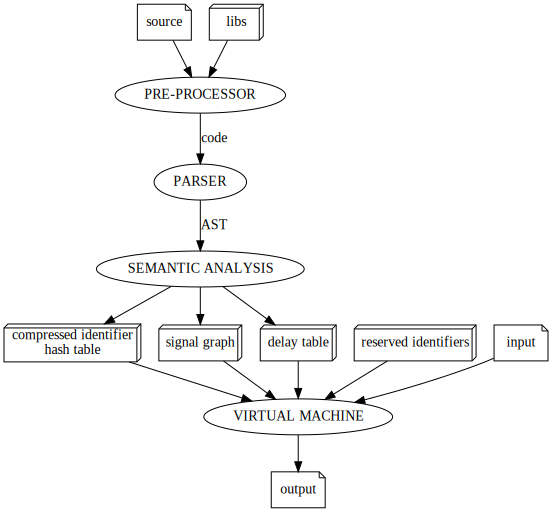

In [20]:
from graphviz import Digraph
dot = Digraph(comment="OpenDSPL Interpreter Architecture")
dot.node('S', 'source', shape='note')
dot.node('L', 'libs', shape='box3d')
dot.node('P', 'PRE-PROCESSOR')
dot.edges(['SP', 'LP'])
dot.node('par', 'PARSER')
dot.edge('P', 'par', label='code')
dot.node('I', 'SEMANTIC ANALYSIS')
dot.edge('par', 'I', 'AST')
dot.node('C', 'compressed identifier\nhash table', shape='box3d')
dot.node('G', 'signal graph', shape='box3d')
dot.node('D', 'delay table', shape='box3d')
dot.node('R', 'reserved identifiers', shape='box3d')
dot.node('N', 'input', shape='note')
dot.node('M', 'VIRTUAL MACHINE')
dot.edges(['IC', 'IG', 'ID', 'CM', 'GM', 'RM', 'NM', 'DM'])
dot.node('out', 'output', shape='note')
dot.edge('M', 'out')
dot

## Parser Design
The parser simply configures and runs an Arpeggio parser, using a PEG-style grammar.

## Semantic Analysis
The interpreter has the task of traversing the validated AST produced by the parser and
converting it into useful datastructures for the virtual machine. The datastructures it
produces are a hash-table storing identifiers and their associated expressions, and a
graph that describes how the output of each identifier being evaluated relates to every
other identifier.

First, a syntactic analyzer reduces all expressions to their most simple form, then
each identifier is checked for undefined references (the syntactic analysis works by
passing a 'partial' object which contains all references to undefined identifiers,
which are removed whenever that identifier is defined, until at the root level, it
should be empty. If it isn't there are undefined references. This generates an
expression table).

The 'partial' object also keeps track of max delay depth as well as a statement table
containing the sequence of statements. Each expression table can contain statement
tables, and vice versa, creating a tree structure.

Once the root node is visited by the semantic analyzer, the return 'partial' object
contains:
1. a hash table containing the values of all identifiers
2. a table of delay variables, and wether their max depth is defined (and which val)
    or not defined
3. a table containing undefined identifiers

Based on these outputs, semantic errors are raised. Afterwards, transformations on
the produced data structures are performed.

The way this is performed is by first creating a hash-table for the identifiers, then
reducing it in size as much as possible, by substituting identifiers with their
associated expressions, until the last remaining identifiers are all un-reduceable.
This is called identifier compression.

After this step, a graph is generated, with a node for each surviving identifier, with
an in-going connection from each undefined identifier it depends from and an out-going
connection for each identifier that depends on it.

Finally, every graph that doesn't end in a sink should raise a warning, every graph
that has no source should raise an error.

## Virtual Machine Design

The first step in the execution of the code is building a source table. For each graph
all the sources are identified and the files they refer to are opened. Then the sink
table is built. For each sink in the graph, the related files are opened.

Each source in the source table has a specified sample rate. The main clock rate that
will drive all sources is derived from the individual sample rates by taking their
least common multiple (LCM). Then the "clock period" for each source's clock (the
number of main samples from one source sample to the next. This step is necessary for
clock synchronization. Each source sends an event out every time the clock period has
elapsed. Each source has thus a counter for counting main clock events.